In [1]:
import pandas as pd
import xarray as xr

dir_list_df = pd.read_csv('/user/ab5405/summeraliaclimate/code/dir_list.csv', index_col=0)
dir_list = dir_list_df['dir_path'].to_dict()


In [2]:
from funcs_support import get_filepaths

df_paths = get_filepaths(source_dir='proc', dir_list=dir_list)
df_paths.head()

,varname,freq,model,exp,run,gwl,proj_method,proj_base,dwnscl_method,dwnscl_target,suffix,filetype,path
0,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r22i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
1,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r1i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
2,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r2i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
3,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r11i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
4,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r25i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...


In [14]:
df = df_paths.query("varname == 'tasdmgfparams' and gwl == 'ALLGWLs'").copy()
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [15]:
import numpy as np
import pandas as pd

In [19]:
dmgf_dng = xr.DataArray([0.69,0.59,0.64,0.36,0.27,0,0.12,0.23,0.33,0.94],dims=['bin'],coords=[np.arange(1,11)])
bins_dng = np.append(np.append(-np.inf,(np.arange(10,91,10)+459.67)*5/9),np.inf)
bin_name_dng = '_dng'

# This was total county income, Table 3. Wanted Table 2 instead
#dmgf_dnh = xr.DataArray([6.55,4.28,-1.73,-5.74,-10.61,-5.47,-3.12,-2.47,-1.07,-1.00,0,-2.77,-7.46,-6.92,-14.78,-16.71,-20.56],
#                          dims=['bin'],coords=[np.arange(1,18)])

# This is from table 2: "The effect of daily temperature on log total annual income per capita"
dmgf_dnh = xr.DataArray([0.000234,0.000126,-0.000144,-0.000269,-0.000322,-0.000195,-0.000119,-0.000074,-0.000003,-0.000036,
                         0,-0.000111,-0.000311,-0.000294,-0.000585,-0.000646,-0.000757],
                           dims=['bin'],coords=[np.arange(1,18)])
bins_dnh = np.append(np.append(-np.inf,np.arange(-15,31,3)+273.15),np.inf)
bin_name_dnh = '_dnh'

In [45]:
def rebin(diff, bin_edges, new_dim_name):
    return diff.groupby_bins('bin_f', bins=bin_edges, labels=np.arange(1, len(bin_edges)), right=False)\
               .sum('bin_f')\
               .rename({f'bin_f_bins': new_dim_name})

In [58]:
impact_dng_list = []
impact_dnh_list = []
model_labels = []
run_labels = []

for i, row in df.iterrows():
    ds = xr.open_zarr(row['path'])

    gwl_2 = ds['bins_behrer'].sel(gwl=2.0, method='nearest')
    gwl_06 = ds['bins_behrer'].sel(gwl=0.61, method='nearest')
    diff = gwl_2 - gwl_06 

    rebinned_dng = rebin(diff, bins_dng, 'bin_dng')
    impact_dng = (rebinned_dng * dmgf_dng).sum(dim='bin_dng')

    rebinned_dnh = rebin(diff, bins_dnh, 'bin_dnh')
    impact_dnh = (rebinned_dnh * dmgf_dnh).sum(dim='bin_dnh')

    impact_dng_list.append(impact_dng)
    impact_dnh_list.append(impact_dnh)
    model_labels.append(row['model'])
    run_labels.append(row['run'])

In [47]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [48]:
impact_plot_mortality = impact_dng_list[0].sum(dim='bin') 
impact_plot_gdp = impact_dnh_list[0].sum(dim = 'bin')

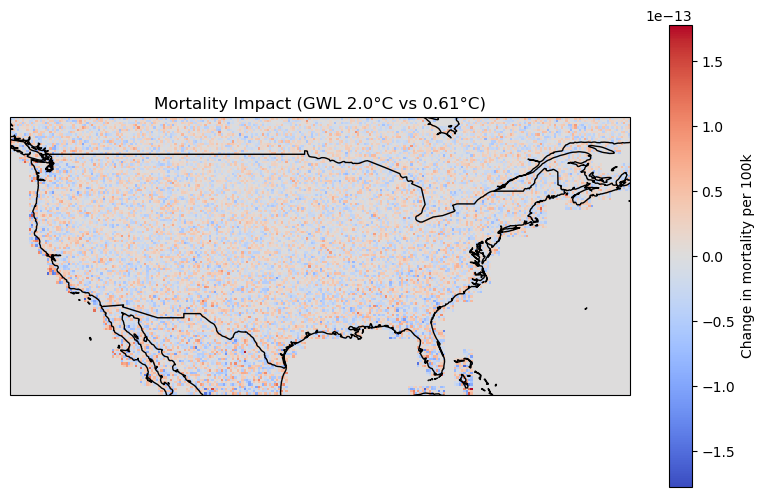

In [57]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

impact_plot_mortality.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    cbar_kwargs={'label': 'Change in mortality per 100k'}
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("Mortality Impact (GWL 2.0°C vs 0.61°C)")

plt.show()


In [50]:
print(impact_plot_gdp.dims)


('lat', 'lon')


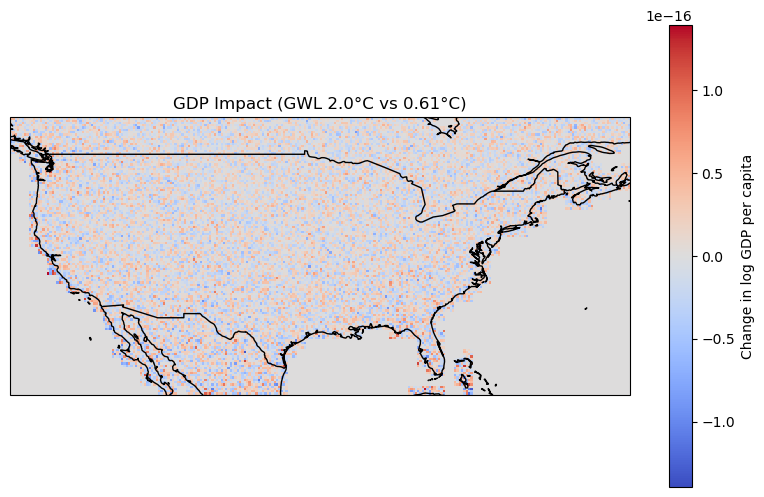

In [56]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

impact_plot_gdp.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    cbar_kwargs={'label': 'Change in log GDP per capita'} 
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title("GDP Impact (GWL 2.0°C vs 0.61°C)")
plt.show()
